# Image Recognition Project - Structural Defect Recognition
---------------------------------------------------------------
## Data Visualisation

### Section Objectives
 - Complete the project objective and answer the business requirements by training the -

 --------------------------------------------------------------

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
import joblib

sns.set_style("whitegrid")

## Setting Working Directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/ML_Project_Image_Recognition')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/ML_Project_Image_Recognition'

## Setting Input and Output Directories

### Input:

In [6]:
base_path = 'inputs/cracks_dataset_new' 

train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

datasets = os.listdir(train_path)
print("Detected datasets in training set:", datasets)


Detected datasets in training set: ['Decks', 'Pavements', 'Walls']


### Output:

In [7]:
version = 'v1'
output_path = os.path.join('outputs', version)

if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Created output folder at: {output_path}")
else:
    print(f"Output folder already exists: {output_path}")

Output folder already exists: outputs/v1


Setting Dataset Labels

In [8]:
dataset_labels = {}

for dataset in datasets:
    dataset_path = os.path.join(train_path, dataset)
    if os.path.isdir(dataset_path):
        labels = os.listdir(dataset_path)
        dataset_labels[dataset] = labels

print("Dataset → Classes:")
for k, v in dataset_labels.items():
    print(f"• {k}: {v}")

Dataset → Classes:
• Decks: ['Cracked', 'Non-cracked']
• Pavements: ['Cracked', 'Non-cracked']
• Walls: ['Cracked', 'Non-cracked']


In [9]:
def plot_image_dimensions(dataset_name):
    dim1, dim2 = [], []
    print(f"\n🔍 Processing image sizes for: {dataset_name}")

    for label in dataset_labels[dataset_name]:  
        class_path = os.path.join(train_path, dataset_name, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = imread(img_path)
                h, w = img.shape[:2]
                dim1.append(h)
                dim2.append(w)
            except:
                continue  

    fig, ax = plt.subplots()
    sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
    ax.set_xlabel("Width (px)")
    ax.set_ylabel("Height (px)")
    ax.set_title(f"Image Size Distribution — {dataset_name}")

    mean_w = int(np.mean(dim2))
    mean_h = int(np.mean(dim1))
    ax.axvline(mean_w, color='r', linestyle='--', label=f"Mean Width: {mean_w}px")
    ax.axhline(mean_h, color='g', linestyle='--', label=f"Mean Height: {mean_h}px")
    plt.legend()
    plt.show()

    return mean_h, mean_w


🔍 Processing image sizes for: Walls


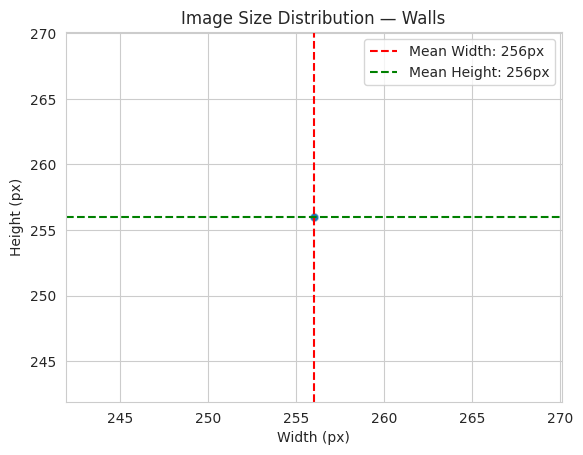


🔍 Processing image sizes for: Decks


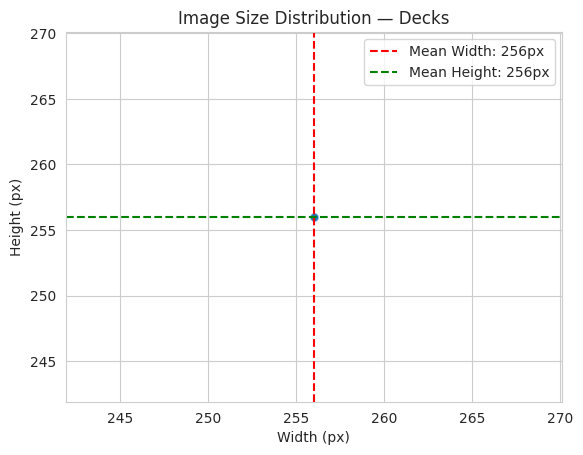


🔍 Processing image sizes for: Pavements


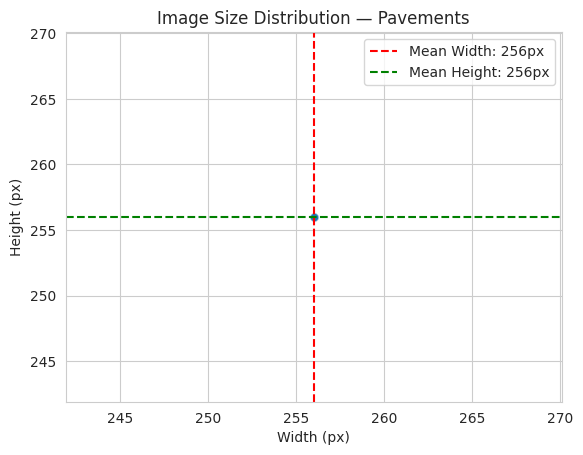

In [10]:
walls_shape = plot_image_dimensions('Walls')
decks_shape = plot_image_dimensions('Decks')
pavements_shape = plot_image_dimensions('Pavements')

In [11]:
image_shape = (256, 256, 3)
print("Image shape to be saved:", image_shape)

joblib.dump(image_shape, os.path.join(output_path, "image_shape.pkl"))
print(f"Image shape saved to: {output_path}/image_shape.pkl")

Image shape to be saved: (256, 256, 3)
Image shape saved to: outputs/v1/image_shape.pkl
